# Metric-Aware Neighborhood Aggregation (MANA)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors

import scanpy as sc
import squidpy as sq
import cellcharter as cc
import scvi

from pandas.api.types import is_numeric_dtype, is_categorical_dtype
from scipy.sparse import issparse


# ------------------------------------------------------------------
# 1) Define and apply course + region + sample_id order
# ------------------------------------------------------------------
course_order = [
    "MOG CFA",
    "early onset",
    "chronic peak",
    "chronic long",

    "PLP CFA",
    "non symptomatic",
    "monophasic",

    "onset I",
    "onset II",
    "peak I",
    "remitt I",
    "peak II",
    "remitt II",
    "peak III",
]

region_order = ["L", "T", "C"]


def apply_course_region_and_sample_order(ad, sample_key="sample_id"):
    """Make ad.obs['course'], ad.obs['region'], and ad.obs[sample_key] ordered categoricals."""
    # --- course ---
    if "course" in ad.obs.columns:
        ad.obs["course"] = ad.obs["course"].astype(
            pd.CategoricalDtype(categories=course_order, ordered=True)
        )

    # --- region ---
    if "region" in ad.obs.columns:
        ad.obs["region"] = ad.obs["region"].astype(
            pd.CategoricalDtype(categories=region_order, ordered=True)
        )

    # --- sample_id ordered by (course, region, sample_id) ---
    if (
        sample_key in ad.obs.columns
        and "course" in ad.obs.columns
        and "region" in ad.obs.columns
    ):
        tmp = (
            ad.obs[[sample_key, "course", "region"]]
            .drop_duplicates()
            .dropna(subset=["course", "region"])
            .copy()
        )

        tmp["course"] = tmp["course"].astype(
            pd.CategoricalDtype(categories=course_order, ordered=True)
        )
        tmp["region"] = tmp["region"].astype(
            pd.CategoricalDtype(categories=region_order, ordered=True)
        )

        tmp = tmp.sort_values(["course", "region", sample_key])
        sample_order = tmp[sample_key].tolist()

        ad.obs[sample_key] = ad.obs[sample_key].astype(
            pd.CategoricalDtype(categories=sample_order, ordered=True)
        )

        ad.uns[f"{sample_key}_order_by_course_region"] = sample_order

    return ad


# ------------------------------------------------------------------
# 2) Plot function (obs + genes, ordered groupby, shared vmin/vmax)
# ------------------------------------------------------------------
def plot_spatial_compact_fast(
    ad,
    color="leiden_2",       # obs column *or* gene name
    groupby="sample_id",
    spot_size=8,
    cols=3,
    height=8,
    legend_col_width=1.2,
    palette=None,
    rasterized=True,
    invert_y=True,
    dpi=120,
    highlight=None,
    group_order=None,
    background="white",
    grey_alpha=0.2,         # alpha for non-highlighted categories
    vmin=None,
    vmax=None,
    cmap_name="viridis",
    shared_scale=False,     # if True: vmin/vmax from whole `ad` (not per subset)
):
    # pick background + text color
    fig_face = background
    ax_face = background
    text_color = "white" if background in ("black", "#000000", "k") else "black"

    # ----- 0) Preconditions -----
    if "spatial" not in ad.obsm:
        raise ValueError("ad.obsm['spatial'] not found")

    if groupby not in ad.obs.columns:
        raise KeyError(f"groupby {groupby!r} not in ad.obs")

    # decide where 'color' comes from: obs vs var (gene)
    if color in ad.obs.columns:
        color_source = "obs"
        col_series = ad.obs[color]
    elif color in ad.var_names:
        color_source = "var"   # gene expression
        col_series = None
    else:
        raise KeyError(
            f"{color!r} not found in ad.obs.columns or ad.var_names "
            "(expected an obs column or a gene name)."
        )

    coords = np.asarray(ad.obsm["spatial"])[:, :2]

    # Detect continuous vs categorical
    if color_source == "var":
        # genes: always continuous
        is_continuous = True
    else:
        if is_categorical_dtype(col_series):
            is_continuous = False
        else:
            is_continuous = is_numeric_dtype(col_series)

    # ----------------------------------------------------
    # 1) Build colors_arr differently for cont vs cat
    # ----------------------------------------------------
    if is_continuous:
        # ===== CONTINUOUS MODE =====
        if color_source == "obs":
            vals = col_series.to_numpy(dtype=float)
        else:
            # from var / gene expression
            gene_idx = ad.var_names.get_loc(color)
            x = ad.X[:, gene_idx]
            if issparse(x):
                vals = x.toarray().ravel()
            else:
                vals = np.asarray(x).ravel()

        # choose colormap
        if palette is None:
            cmap = plt.get_cmap(cmap_name)
        elif isinstance(palette, str):
            cmap = plt.get_cmap(palette)
        else:
            cmap = palette

        # ----- determine vmin/vmax -----
        if shared_scale:
            # global min/max across the *full AnnData* passed to this function
            full = ad
            if color_source == "var":
                gx = full.X[:, full.var_names.get_loc(color)]
                if issparse(gx):
                    full_vals = gx.toarray().ravel()
                else:
                    full_vals = np.asarray(gx).ravel()
            else:
                full_vals = pd.to_numeric(full.obs[color], errors="coerce").to_numpy()

            finite_full = np.isfinite(full_vals)
            if finite_full.sum() == 0:
                raise ValueError(f"All values for '{color}' are NaN or non-finite.")
            vmin_use = float(np.min(full_vals[finite_full]))
            vmax_use = float(np.max(full_vals[finite_full]))
        else:
            finite_mask = np.isfinite(vals)
            if finite_mask.sum() == 0:
                raise ValueError(f"All values for '{color}' are NaN or non-finite.")
            vmin_use = float(np.min(vals[finite_mask]))
            vmax_use = float(np.max(vals[finite_mask]))

        # user overrides everything
        if vmin is not None:
            vmin_use = float(vmin)
        if vmax is not None:
            vmax_use = float(vmax)

        # avoid zero-range
        if vmin_use == vmax_use:
            vmin_use -= 1.0
            vmax_use += 1.0

        norm = mcolors.Normalize(vmin=vmin_use, vmax=vmax_use)

        colors_arr = np.zeros((vals.size, 4), dtype=float)
        finite_mask = np.isfinite(vals)
        colors_arr[finite_mask] = cmap(norm(vals[finite_mask]))
        colors_arr[~finite_mask] = (0, 0, 0, 0)

        # store continuous settings in uns (also fine for genes)
        ad.uns[f"{color}_continuous"] = {
            "vmin": float(vmin_use),
            "vmax": float(vmax_use),
            "cmap": cmap.name if hasattr(cmap, "name") else str(cmap),
        }

        cat_names = None
        cat_codes = None

    else:
        # ===== CATEGORICAL (only for obs) =====
        # preserve existing categorical order if present
        if is_categorical_dtype(col_series):
            cats = col_series.cat.remove_unused_categories()
        else:
            cats = col_series.astype("category")

        cat_names = cats.cat.categories
        cat_codes = cats.cat.codes.to_numpy()

        # palette handling
        if isinstance(palette, dict):
            col_list = [palette[c] for c in cat_names]
        elif isinstance(palette, (list, tuple)):
            if len(palette) < len(cat_names):
                raise ValueError("Palette shorter than number of categories.")
            col_list = list(palette)[:len(cat_names)]
        elif f"{color}_colors" in ad.uns:
            col_list = list(ad.uns[f"{color}_colors"])
            if len(col_list) != len(cat_names):
                raise ValueError(f"{color}_colors length != categories.")
        else:
            base = list(
                sc.pl.palettes.default_64
                if hasattr(sc.pl.palettes, "default_64")
                else sc.pl.palettes.default_102
            )
            reps = int(np.ceil(len(cat_names) / len(base)))
            col_list = (base * reps)[:len(cat_names)]

        ad.uns[f"{color}_colors"] = col_list

        rgba = np.array([mcolors.to_rgba(c) for c in col_list], dtype=float)

        colors_arr = np.empty((cat_codes.size, 4), dtype=float)
        colors_arr[cat_codes >= 0] = rgba[cat_codes[cat_codes >= 0]]
        colors_arr[cat_codes < 0] = (0, 0, 0, 0)

        # ----- highlighting logic -----
        if highlight is not None:
            # allow single value or list/tuple/array
            if not isinstance(highlight, (list, tuple, set, np.ndarray)):
                highlight = [highlight]
            # convert to string for robust matching
            highlight_str = {str(h) for h in highlight}

            cat_name_str = np.array([str(c) for c in cat_names])
            keep_cat_mask = np.isin(cat_name_str, list(highlight_str))  # per-category

            # use user-defined alpha for greyed-out categories
            grey_rgba = (0.8, 0.8, 0.8, float(grey_alpha))

            valid = cat_codes >= 0
            keep_flag = np.zeros_like(cat_codes, dtype=bool)
            keep_flag[valid] = keep_cat_mask[cat_codes[valid]]

            # grey out all non-highlighted cells
            colors_arr[valid & ~keep_flag] = grey_rgba

            # also grey in legend
            col_list = [
                col_list[k] if keep_cat_mask[k] else mcolors.to_hex(grey_rgba)
                for k in range(len(cat_names))
            ]

    # ----------------------------------------------------
    # 2) Precompute group indices (RESPECT ORDERED CATEGORICAL)
    # ----------------------------------------------------
    gser = ad.obs[groupby]

    if group_order is not None:
        group_order = [str(g) for g in group_order]
        present = set(gser.astype(str))
        uniq_groups = [g for g in group_order if g in present]
    else:
        # if groupby is an ordered categorical, respect its category order
        if is_categorical_dtype(gser) and gser.cat.ordered:
            cats = list(gser.cat.categories)
            present = set(gser.astype(str))
            uniq_groups = [str(c) for c in cats if str(c) in present]
        else:
            # fallback: sorted unique strings
            uniq_groups = sorted(gser.astype(str).unique())

    gvals = gser.astype(str).to_numpy()
    gid_to_idx = {g: i for i, g in enumerate(uniq_groups)}
    gcodes = np.array([gid_to_idx.get(g, -1) for g in gvals], dtype=int)

    group_indices = [np.flatnonzero(gcodes == gi) for gi in range(len(uniq_groups))]

    # ----------------------------------------------------
    # 3) Figure layout
    # ----------------------------------------------------
    n = len(uniq_groups)
    rows = int(np.ceil(n / cols))
    panel_w = height * cols * 0.6 / rows
    fig_w = panel_w + legend_col_width

    plt.ioff()
    fig = plt.figure(figsize=(fig_w, height), dpi=dpi, constrained_layout=False)

    # background for figure
    fig.patch.set_facecolor(fig_face)

    gs = GridSpec(
        rows, cols + 1, figure=fig,
        width_ratios=[1]*cols + [legend_col_width / (fig_w - legend_col_width)],
        wspace=0.02, hspace=0.02
    )

    # ----------------------------------------------------
    # 4) Panels
    # ----------------------------------------------------
    for i, sid in enumerate(uniq_groups):
        r, c = divmod(i, cols)
        ax = fig.add_subplot(gs[r, c])

        # panel background
        ax.set_facecolor(ax_face)

        idx = group_indices[i]
        if idx.size:
            xy = coords[idx]
            ax.scatter(
                xy[:, 0], -xy[:, 1],
                c=colors_arr[idx],
                s=spot_size,
                marker='o',
                linewidths=0,
                rasterized=rasterized
            )

        meta_strings = []

        if "region" in ad.obs.columns:
            region_vals = (
                ad.obs.loc[ad.obs[groupby] == sid, "region"]
                .dropna().astype(str).unique()
            )
            if len(region_vals) == 0:
                meta_strings.append("Region: unknown")
            elif len(region_vals) == 1:
                meta_strings.append(f"Region: {region_vals[0]}")
            else:
                meta_strings.append("Region: mixed")

        if "course" in ad.obs.columns:
            course_vals = (
                ad.obs.loc[ad.obs[groupby] == sid, "course"]
                .dropna().astype(str).unique()
            )
            if len(course_vals) == 0:
                meta_strings.append("Course: unknown")
            elif len(course_vals) == 1:
                meta_strings.append(f"Course: {course_vals[0]}")
            else:
                meta_strings.append("Course: mixed")

        if meta_strings:
            title = f"{sid}\n[{ ' | '.join(meta_strings) }]"
        else:
            title = str(sid)

        ax.set_title(title, fontsize=5, pad=2, color=text_color)
        ax.set_aspect("equal")
        if invert_y:
            ax.invert_yaxis()
        ax.set_axis_off()

    # blank unused panels
    for j in range(n, rows * cols):
        r, c = divmod(j, cols)
        ax = fig.add_subplot(gs[r, c])
        ax.set_facecolor(ax_face)
        ax.axis("off")

    # ----------------------------------------------------
    # 5) Legend / Colorbar
    # ----------------------------------------------------
    ax_leg = fig.add_subplot(gs[:, -1])
    ax_leg.set_facecolor(ax_face)
    ax_leg.axis("off")

    if is_continuous:
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=ax_leg)
        cbar.set_label(color, rotation=90, color=text_color)
        cbar.ax.yaxis.set_tick_params(color=text_color)
        plt.setp(plt.getp(cbar.ax.axes, "yticklabels"), color=text_color)
    else:
        handles = [
            Line2D(
                [0], [0], marker="o", color="w",
                markerfacecolor=col_list[k], markersize=7, label=str(cat)
            )
            for k, cat in enumerate(cat_names)
        ]
        leg = ax_leg.legend(
            handles=handles,
            title=color,
            frameon=False,
            loc="center left",
            labelcolor=text_color,
            title_fontsize=10
        )
        leg.get_title().set_color(text_color)
        for text in leg.get_texts():
            text.set_color(text_color)

    fig.subplots_adjust(
        left=0.01, right=0.98, top=0.98, bottom=0.02,
        wspace=0.02, hspace=0.02
    )

    plt.ion()
    plt.show()


In [5]:
import scanpy as sc
import sys
print(sys.version)
print(sys.executable)

3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:56:31) [Clang 19.1.7 ]
/Users/chrislangseth/miniforge3/envs/cellcharter/bin/python


In [6]:
basedir = '/Volumes/processing2/RRmap/data/'

In [7]:
ad = sc.read_h5ad(basedir + 'EAE_proseg_clustered_louvain_leiden_all_sections_annotated_rotated_cellcharter_neigh2_251219.h5ad')

# subset for testing

In [241]:
samples = ['S3_B3_0','S1_T3_1','G4_L2_0','S2_T1_1','S1_B3_2','S1_T1_0','S1_B1_2', 'S3_B3_0', 'G3_L1_1', 'S4_B3_0']

In [242]:
ad_sub = ad[ad.obs.sample_id.isin(samples)]

In [243]:
ad_sub.X.max()

np.int64(1158)

In [244]:
ad_sub = ad_sub.copy()

In [245]:
ad_sub.layers['counts'] = ad_sub.X

In [246]:
scvi.model.SCVI.setup_anndata(
    ad_sub, 
    layer="counts", 
)

model = scvi.model.SCVI(ad_sub)

In [ ]:
model.train(early_stopping=True, max_epochs = 20, enable_progress_bar=True)

Epoch 15/20:  70%|▋| 14/20 [06:54<03:02, 30.47s/it, v_num=1, train_loss=2.26e+3]

In [ ]:
ad_sub.obsm['X_scVI'] = model.get_latent_representation(ad_sub).astype(np.float32)

In [ ]:
import squidpy as sq

sq.gr.spatial_neighbors(
    ad_sub,
    coord_type="generic",
    radius=100.0,      # microns-ish; tune to your segmentation density
    delaunay=False,
    library_key = 'sample_id',
)

In [ ]:
import scipy.sparse as sp
import numpy as np

def row_normalize_csr(M: sp.csr_matrix) -> sp.csr_matrix:
    rs = np.asarray(M.sum(axis=1)).ravel()
    rs[rs == 0] = 1.0
    return sp.diags(1.0 / rs) @ M

def make_distance_weighted_W(
    distances: sp.csr_matrix,
    kernel: str = "gaussian",
    sigma: float = None,    # if None, we'll estimate from graph distances
    lam: float = None,
    eps: float = 1e-12,
) -> sp.csr_matrix:
    D = distances.tocsr().copy()
    d = D.data

    if kernel == "gaussian":
        if sigma is None:
            sigma = np.median(d)  # simple, usually works well
        w = np.exp(-(d**2) / (2 * (sigma**2) + eps))
    elif kernel == "exponential":
        if lam is None:
            lam = np.median(d)
        w = np.exp(-d / (lam + eps))
    else:
        raise ValueError("kernel must be 'gaussian' or 'exponential'")

    D.data = w
    return row_normalize_csr(D)

W = make_distance_weighted_W(
    ad_sub.obsp["spatial_distances"],
    kernel="gaussian",
    sigma=40# None,   # uses median neighbor distance
)

In [ ]:
import numpy as np

def distance_weighted_multilayer_embedding(
    X: np.ndarray,
    W: sp.csr_matrix,
    n_layers: int = 3,
    include_self: bool = True,
) -> np.ndarray:
    feats = [X] if include_self else []
    Xk = X
    for _ in range(n_layers):
        Xk = W @ Xk
        feats.append(Xk)
    return np.concatenate(feats, axis=1)

X = ad_sub.obsm["X_scVI"]
ad_sub.obsm["X_cellcharter_distw"] = distance_weighted_multilayer_embedding(
    X=X,
    W=W,
    n_layers=8,        # try 2–5
    include_self=True,
)

In [ ]:
ad_sub.obsm["X_cellcharter_distw"] = ad_sub.obsm["X_cellcharter_distw"].astype("float32")

In [ ]:
ad_sub.obsm["X_cellcharter_distw"].shape

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

X = ad_sub.obsm["X_cellcharter_distw"].astype(np.float32)

# 30–50 is a good start
X_pca = PCA(n_components=10, random_state=0).fit_transform(X).astype(np.float32)

ad_sub.obsm["X_cellcharter_distw_pca10"] = X_pca

In [ ]:
ad_sub.obsm["X_cellcharter_distw"].shape

In [ ]:
ad_sub.obsm["X_cellcharter_distw_pca10"].shape

In [ ]:
from sklearn.cluster import MiniBatchKMeans

X = ad_sub.obsm["X_cellcharter_distw"]

km = MiniBatchKMeans(
    n_clusters=25,
    random_state=0,
    batch_size=8192,
    n_init=10,
)

ad_sub.obs["dwna_cluster"] = km.fit_predict(X).astype(str)

In [ ]:
if "dwna_cluster_colors" in ad_sub.uns:
    del ad_sub.uns["dwna_cluster_colors"]

In [239]:
ad_sub.obs.dwna_cluster = ad_sub.obs.dwna_cluster.astype(str)

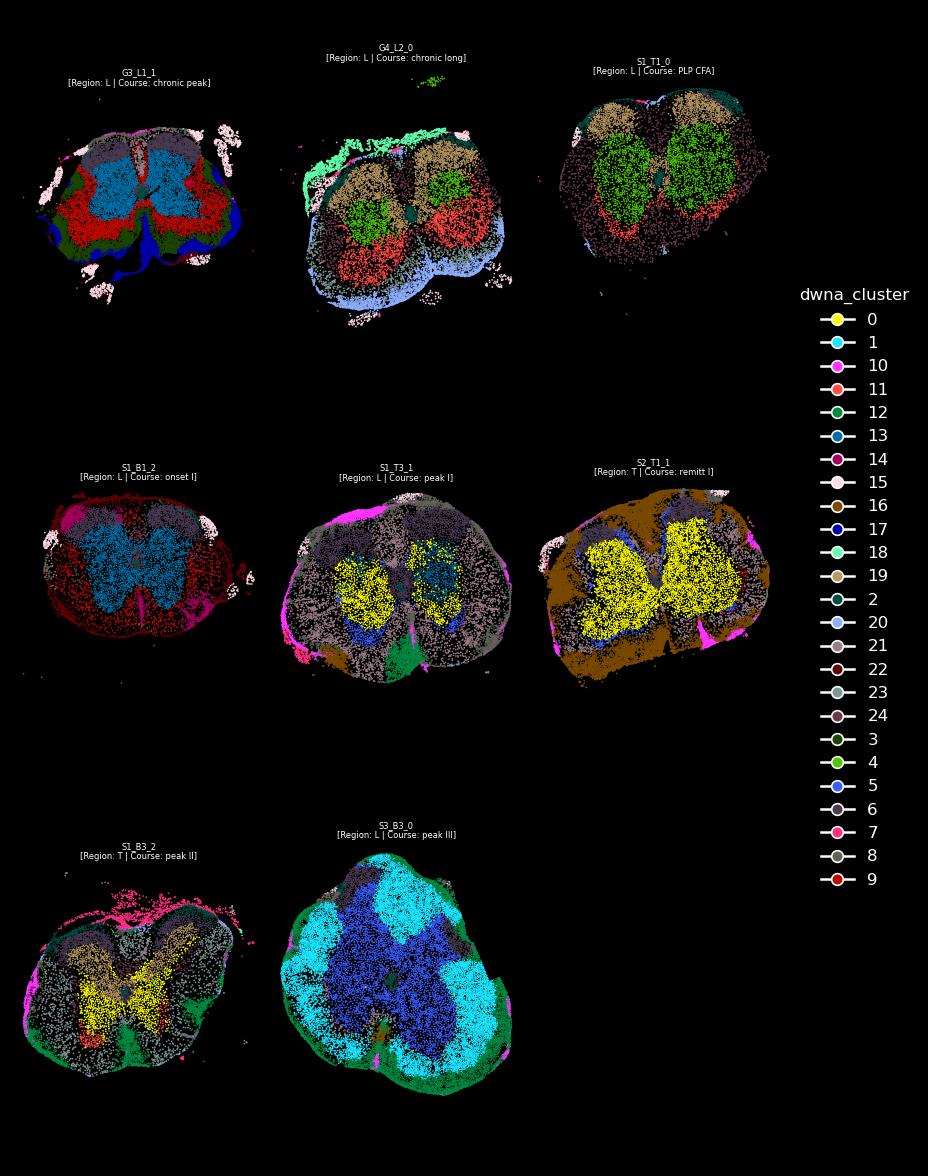

In [240]:
# usage
plot_spatial_compact_fast(
    ad_sub,
    color="dwna_cluster",
    groupby="sample_id",
    spot_size=1,
    cols=3,
    height=10,
    legend_col_width=1.0,
    background="black",
    grey_alpha=0.05,
    #highlight=['4','5']
)

## what are the cluster representing? 

In [74]:
import cellcharter as cc

gmm = cc.tl.Cluster(n_clusters=10, random_state=0)
gmm.fit(ad_sub, use_rep="X_cellcharter_distw_pca10")
ad_sub.obs["spatial_cluster_distw"] = gmm.predict(ad_sub, use_rep="X_cellcharter_distw_pca10")

In [75]:
ad_sub.obs["spatial_cluster_distw"]

cell_id
npbjhhhp-1    2
ekkkkjhg-1    8
ekmlkkdo-1    8
ekmkkhfi-1    8
ekkgfobi-1    8
             ..
nckmikdf-1    2
nclalckk-1    2
nckpdmcl-1    2
nclchghp-1    2
nckebnmh-1    2
Name: spatial_cluster_distw, Length: 44125, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [76]:
d = ad_sub.obsp["spatial_distances"].data
print("neighbor distance median:", np.median(d), "  90th pct:", np.quantile(d, 0.9))

neighbor distance median: 69.08440834509126   90th pct: 94.51778720041713


In [77]:
row_sums = np.asarray(W.sum(axis=1)).ravel()
print("row sums:", np.min(row_sums), np.median(row_sums), np.max(row_sums))

row sums: 0.0 1.0 1.0000000000000007


In [78]:
del ad_sub.uns['spatial_cluster_distw_colors']

Epoch 30/181:  16%|▏| 29/181 [31:06<2:43:02, 64.36s/it, v_num=1, train_loss=2.28


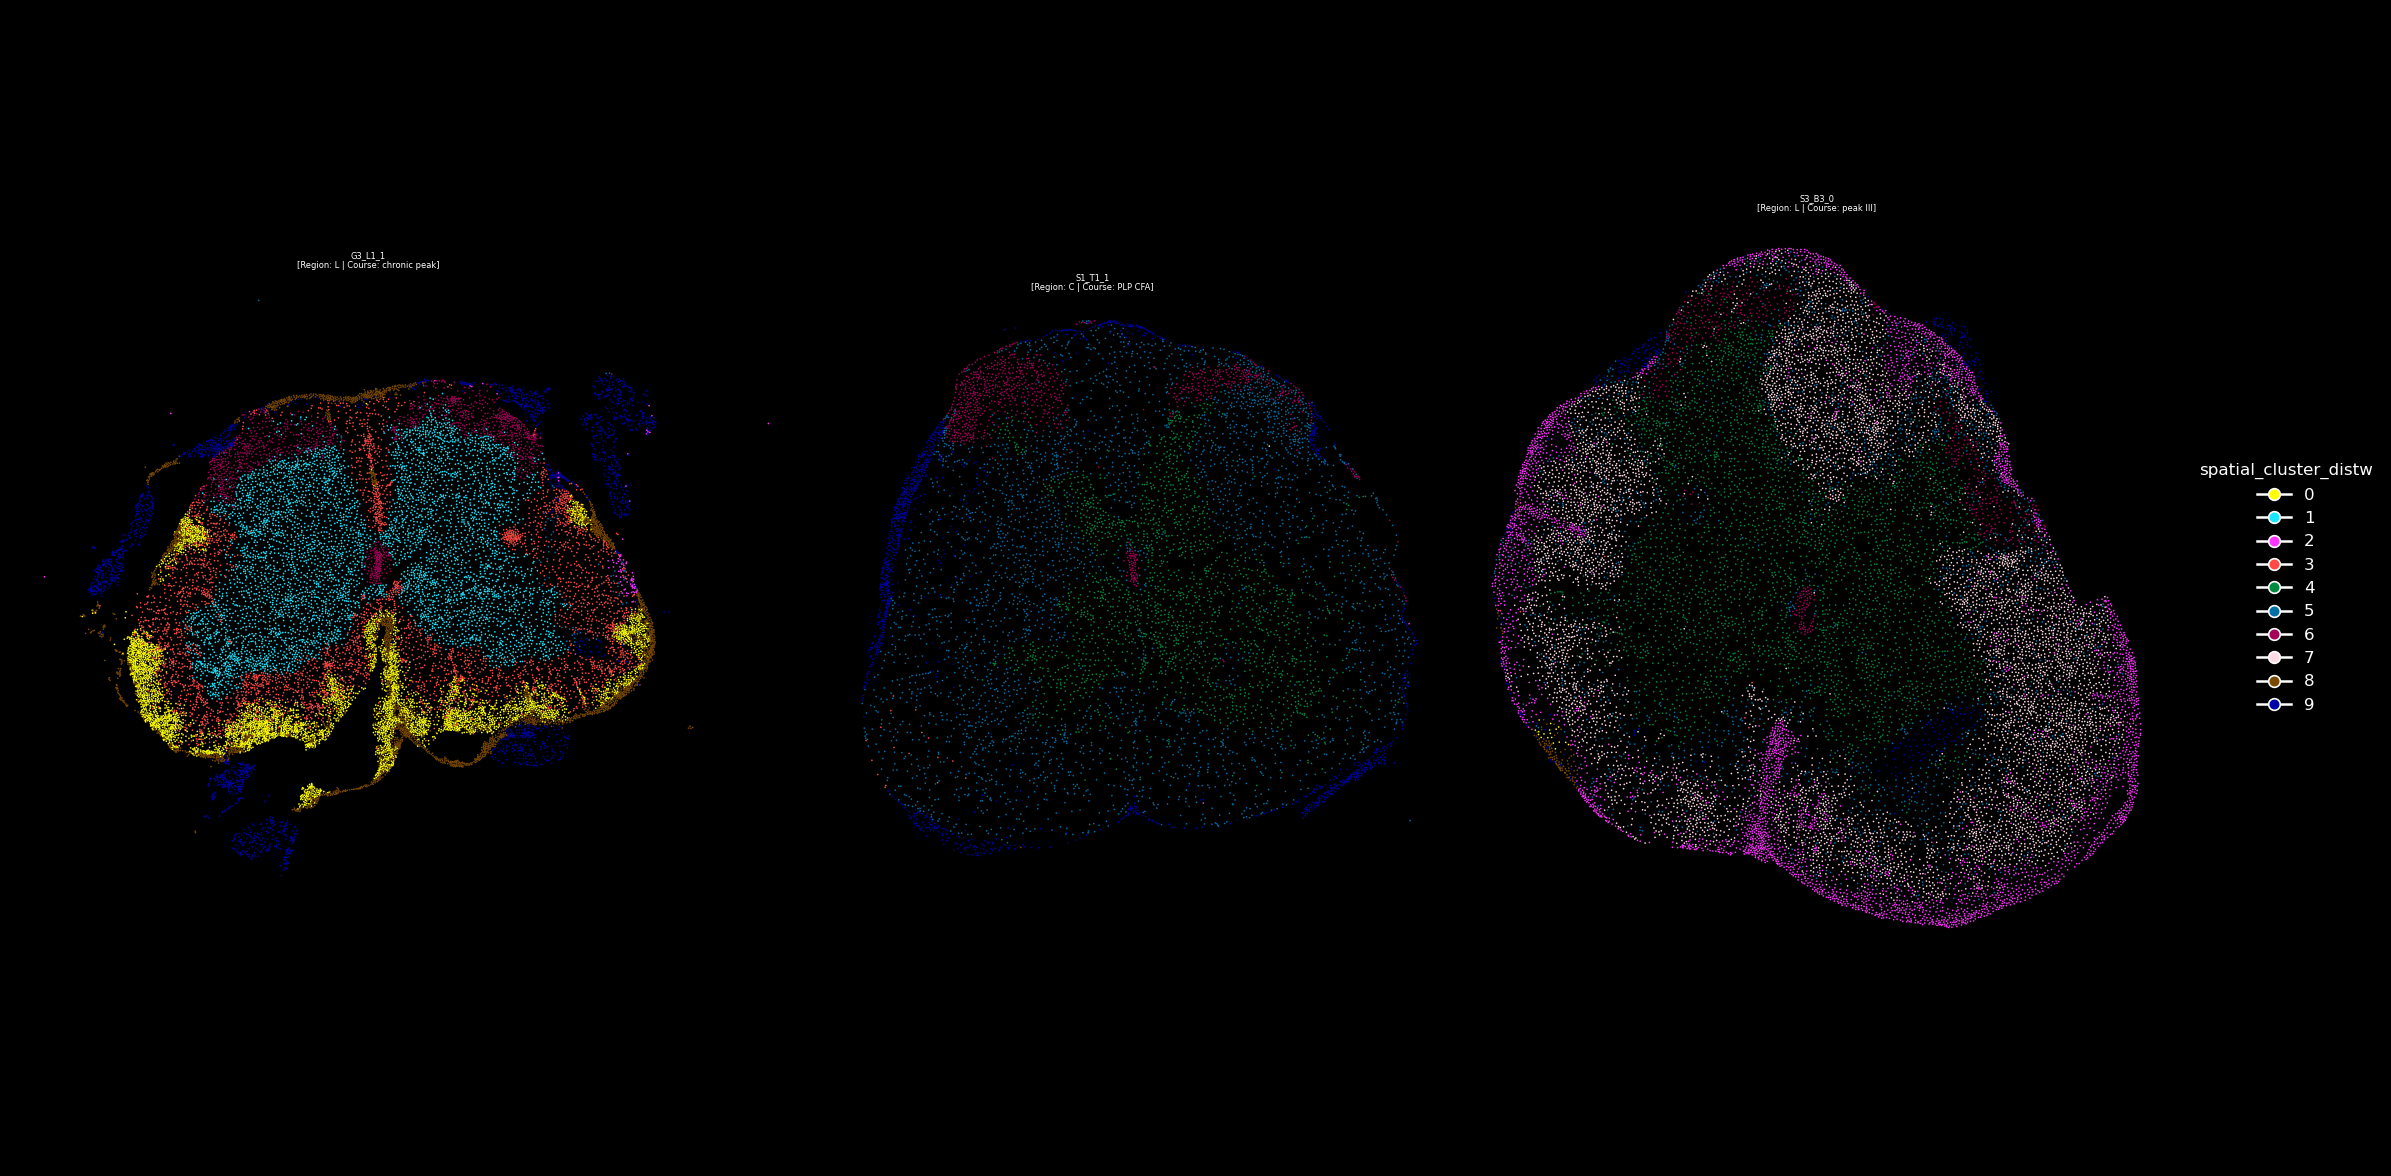

In [79]:
# usage
plot_spatial_compact_fast(
    ad_sub,
    color="spatial_cluster_distw",
    groupby="sample_id",
    spot_size=1,
    cols=3,
    height=10,
    legend_col_width=1.0,
    background="black",
    grey_alpha=0.05,
    #highlight=['4','5']
)

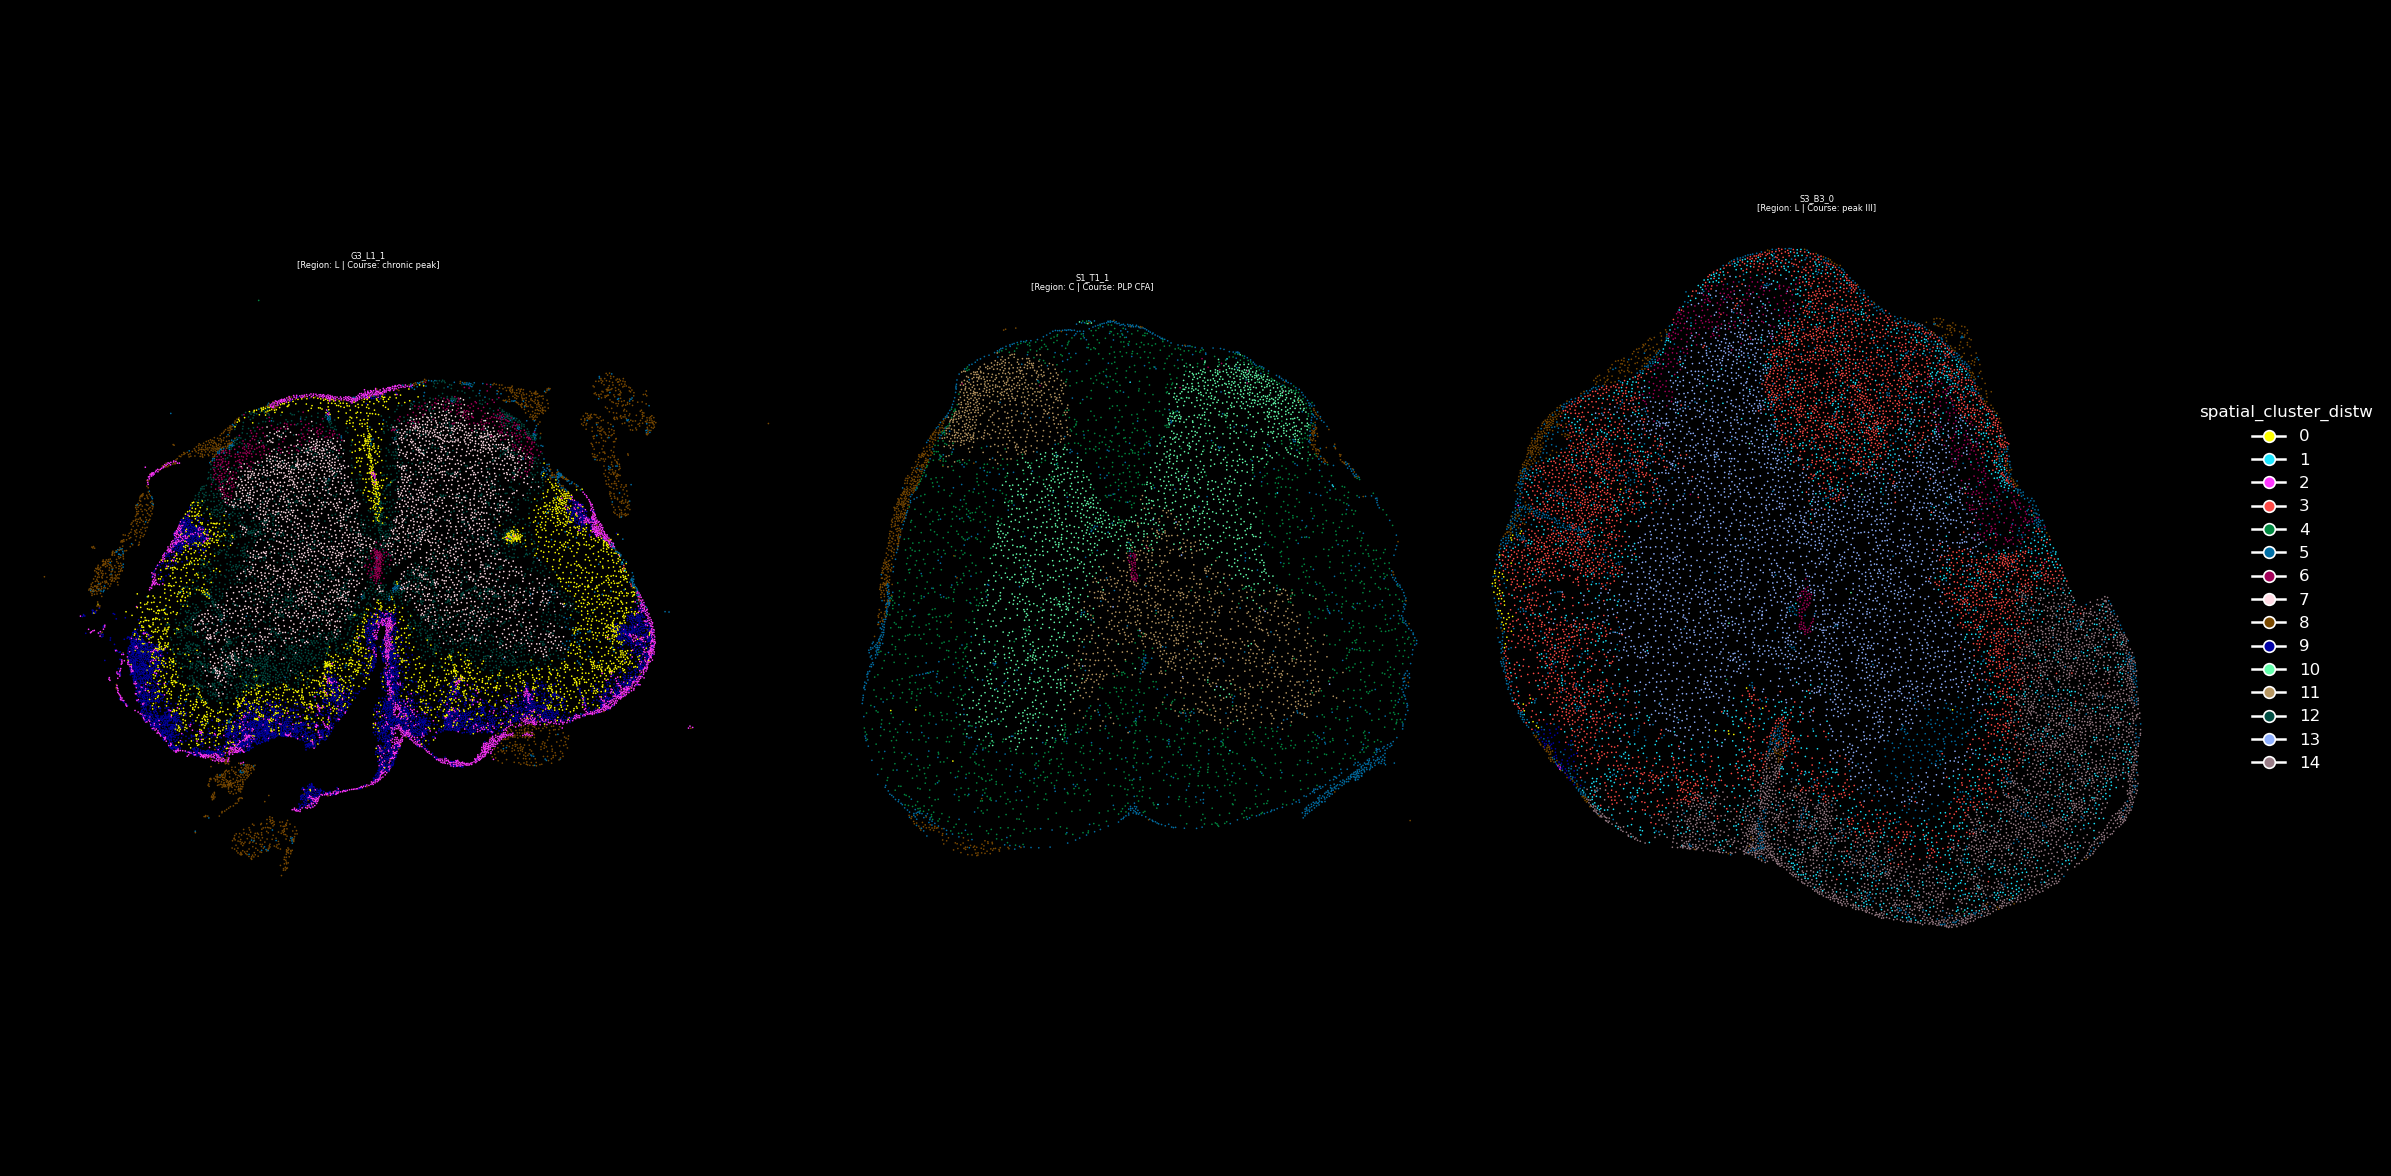

In [65]:
# usage
plot_spatial_compact_fast(
    ad_sub,
    color="spatial_cluster_distw",
    groupby="sample_id",
    spot_size=1,
    cols=3,
    height=10,
    legend_col_width=1.0,
    background="black",
    grey_alpha=0.05,
    #highlight=['4','5']
)